## Pretraining SimSiam

In [ ]:
from PIL import ImageFilter
import random


class TwoCropsTransform:
    """
    A transformation class to create two different random crops of the same image.
    This is used to generate a query (q) and key (k) pair for contrastive learning.
    """

    def __init__(self, base_transform):
        # Initialize with a base transformation (e.g., augmentation pipeline).
        self.base_transform = base_transform

    def __call__(self, x):
        # Apply the base transformation twice to produce two augmented views.
        q = self.base_transform(x)  # First crop (query)
        k = self.base_transform(x)  # Second crop (key)
        return [q, k]  # Return as a list of query and key


class GaussianBlur(object):
    """
    Apply Gaussian blur as an augmentation.
    This is inspired by SimCLR: https://arxiv.org/abs/2002.05709.
    """

    def __init__(self, sigma=[.1, 2.]):
        # Define the range for the standard deviation (sigma) of the Gaussian kernel.
        self.sigma = sigma

    def __call__(self, x):
        # Randomly select a sigma value within the defined range.
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        # Apply Gaussian blur with the selected radius to the input image.
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

In [ ]:
'''
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
# from lib.normalize import Normalize

from torch.autograd import Variable


class BasicBlock(nn.Module):
    """
    Basic building block for ResNet.
    Implements two convolutional layers with Batch Normalization and ReLU activation.
    Includes a shortcut connection to handle dimensionality changes.
    """
    expansion = 1  # Defines how the number of output channels expands

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Shortcut connection for matching dimensions if necessary
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        # Forward pass through convolutional layers and shortcut connection
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Add shortcut connection
        out = F.relu(out)  # Final ReLU activation
        return out


class Bottleneck(nn.Module):
    """
    Bottleneck block for ResNet.
    Implements a three-layer structure to reduce computation while maintaining performance.
    """
    expansion = 4  # Output channels are 4x the input channels

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        # First convolutional layer (1x1)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # Second convolutional layer (3x3)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Third convolutional layer (1x1)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        # Shortcut connection for matching dimensions if necessary
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        # Forward pass through the bottleneck layers and shortcut connection
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)  # Add shortcut connection
        out = F.relu(out)  # Final ReLU activation
        return out


class ResNet(nn.Module):
    """
    ResNet model definition.
    Builds the full network by stacking blocks and applying transformations.
    """

    def __init__(self, block, num_blocks, low_dim=128):
        super(ResNet, self).__init__()
        self.in_planes = 64  # Initial number of input channels

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Stacked layers using blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Fully connected layer for output
        self.fc = nn.Linear(512 * block.expansion, low_dim)
        # self.l2norm = Normalize(2)  # Optional normalization (commented out)

    def _make_layer(self, block, planes, num_blocks, stride):
        """
        Create a layer by stacking multiple blocks.
        Handles downsampling when stride > 1.
        """
        strides = [stride] + [1] * (num_blocks - 1)  # First block handles downsampling
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion  # Update input channels for the next block
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through all layers of the network
        out = F.relu(self.bn1(self.conv1(x)))  # Initial layer
        out = self.layer1(out)  # Layer 1
        out = self.layer2(out)  # Layer 2
        out = self.layer3(out)  # Layer 3
        out = self.layer4(out)  # Layer 4
        out = F.avg_pool2d(out, 4)  # Global average pooling
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc(out)  # Fully connected layer
        # out = self.l2norm(out)  # Optional normalization (commented out)
        return out


# ResNet variants with different depths
def ResNet18(low_dim=128):
    return ResNet(BasicBlock, [2, 2, 2, 2], low_dim)

def ResNet34(low_dim=128):
    return ResNet(BasicBlock, [3, 4, 6, 3], low_dim)

def ResNet50(low_dim=128):
    return ResNet(Bottleneck, [3, 4, 6, 3], low_dim)

def ResNet101(low_dim=128):
    return ResNet(Bottleneck, [3, 4, 23, 3], low_dim)

def ResNet152(low_dim=128):
    return ResNet(Bottleneck, [3, 8, 36, 3], low_dim)



In [ ]:
from torch import nn


class SimSiamLoss(nn.Module):
    """
    Implementation of the SimSiam loss function.
    This loss is designed for self-supervised learning by comparing the similarity
    between pairs of projections and predictions from two augmented views of the same image.

    Reference:
    SimSiam: Exploring Simple Siamese Representation Learning (https://arxiv.org/abs/2011.10566)
    """

    def __init__(self, version='simplified'):
        """
        Initialize the SimSiam loss module.

        Args:
            version (str): Specifies the version of the loss.
                           'original' uses the original dot-product-based formulation,
                           'simplified' uses cosine similarity (default).
        """
        super().__init__()
        self.ver = version

    def asymmetric_loss(self, p, z):
        """
        Compute the asymmetric loss between the prediction (p) and the projection (z).
        This enforces similarity between the two while detaching the gradient from `z`.

        Args:
            p (torch.Tensor): Prediction vector.
            z (torch.Tensor): Projection vector.

        Returns:
            torch.Tensor: Computed loss.
        """
        if self.ver == 'original':
            # Detach z to stop gradient flow
            z = z.detach()

            # Normalize vectors
            p = nn.functional.normalize(p, dim=1)
            z = nn.functional.normalize(z, dim=1)

            # Original formulation: negative dot product
            return -(p * z).sum(dim=1).mean()

        elif self.ver == 'simplified':
            # Detach z to stop gradient flow
            z = z.detach()

            # Simplified formulation: negative cosine similarity
            return -nn.functional.cosine_similarity(p, z, dim=-1).mean()

    def forward(self, z1, z2, p1, p2):
        """
        Compute the SimSiam loss for two pairs of projections and predictions.

        Args:
            z1 (torch.Tensor): Projection vector from the first augmented view.
            z2 (torch.Tensor): Projection vector from the second augmented view.
            p1 (torch.Tensor): Prediction vector corresponding to z1.
            p2 (torch.Tensor): Prediction vector corresponding to z2.

        Returns:
            torch.Tensor: Averaged SimSiam loss.
        """
        # Compute the loss for each pair (p1, z2) and (p2, z1)
        loss1 = self.asymmetric_loss(p1, z2)
        loss2 = self.asymmetric_loss(p2, z1)

        # Average the two losses
        return 0.5 * loss1 + 0.5 * loss2


In [ ]:
# https://github.com/zhirongw/lemniscate.pytorch/blob/master/test.py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch import nn


class KNNValidation(object):
    """
    Perform K-Nearest Neighbors (KNN) validation for self-supervised learning.
    This evaluates the learned representations by checking how well the model
    can classify images using KNN on feature embeddings.

    Args:
        args (Namespace): Configuration arguments including dataset paths, batch size, etc.
        model (nn.Module): The feature extraction model to evaluate.
        K (int): Number of neighbors to consider in KNN. Default is 1.
    """

    def __init__(self, args, model, K=1):
        self.model = model
        self.device = torch.device('cuda' if next(model.parameters()).is_cuda else 'cpu')
        self.args = args
        self.K = K

        # Define base transformations for preprocessing CIFAR-10 dataset
        base_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 normalization
        ])

        # Load CIFAR-10 training dataset
        train_dataset = datasets.CIFAR10(root=args.data_root,
                                         train=True,
                                         download=True,
                                         transform=base_transforms)

        self.train_dataloader = DataLoader(train_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=False,  # No shuffle for consistent feature extraction
                                           num_workers=args.num_workers,
                                           pin_memory=True,
                                           drop_last=True)

        # Load CIFAR-10 validation dataset
        val_dataset = datasets.CIFAR10(root=args.data_root,
                                       train=False,
                                       download=True,
                                       transform=base_transforms)

        self.val_dataloader = DataLoader(val_dataset,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.num_workers,
                                         pin_memory=True,
                                         drop_last=True)

    def _topk_retrieval(self):
        """
        Extract features from the validation dataset and perform KNN search on
        the training dataset features to classify validation images.

        Returns:
            float: Top-1 accuracy of KNN classification on the validation dataset.
        """
        # Number of training data points
        n_data = self.train_dataloader.dataset.data.shape[0]
        feat_dim = self.args.feat_dim  # Feature dimension from the model

        self.model.eval()  # Set model to evaluation mode
        if str(self.device) == 'cuda':
            torch.cuda.empty_cache()  # Clear GPU cache for efficient memory usage

        # Create tensor to store all training features
        train_features = torch.zeros([feat_dim, n_data], device=self.device)
        with torch.no_grad():
            for batch_idx, (inputs, _) in enumerate(self.train_dataloader):
                inputs = inputs.to(self.device)
                batch_size = inputs.size(0)

                # Forward pass to extract features
                features = self.model(inputs)
                features = nn.functional.normalize(features)  # Normalize feature vectors
                train_features[:, batch_idx * batch_size:batch_idx * batch_size + batch_size] = features.data.t()

            # Get training labels
            train_labels = torch.LongTensor(self.train_dataloader.dataset.targets).cuda()

        total = 0
        correct = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(self.val_dataloader):
                targets = targets.cuda(non_blocking=True)
                batch_size = inputs.size(0)

                # Extract features for validation inputs
                features = self.model(inputs.to(self.device))

                # Compute pairwise cosine similarity between validation and training features
                dist = torch.mm(features, train_features)

                # Retrieve top-K neighbors
                yd, yi = dist.topk(self.K, dim=1, largest=True, sorted=True)

                # Get corresponding labels of top-K neighbors
                candidates = train_labels.view(1, -1).expand(batch_size, -1)
                retrieval = torch.gather(candidates, 1, yi)

                # Take the most likely label (top-1 retrieval)
                retrieval = retrieval.narrow(1, 0, 1).clone().view(-1)

                # Update total and correct predictions
                total += targets.size(0)
                correct += retrieval.eq(targets.data).sum().item()

        # Compute top-1 accuracy
        top1 = correct / total
        return top1

    def eval(self):
        """
        Public method to evaluate the model using KNN validation.

        Returns:
            float: Top-1 accuracy.
        """
        return self._topk_retrieval()


In [ ]:
class projection_MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) for projection in SimSiam.
    This module projects the backbone's output to a feature space for contrastive learning.

    Args:
        in_dim (int): Input feature dimension.
        out_dim (int): Output feature dimension.
        num_layers (int): Number of layers in the MLP (default: 2).
    """
    def __init__(self, in_dim, out_dim, num_layers=2):
        super().__init__()
        hidden_dim = out_dim  # Hidden layer dimension
        self.num_layers = num_layers

        # First layer: Fully connected + BatchNorm + ReLU
        self.layer1 = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True)
        )

        # Second layer: Fully connected + BatchNorm + ReLU (optional)
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True)
        )

        # Third layer: Fully connected + BatchNorm without learnable affine parameters
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.BatchNorm1d(out_dim, affine=False)  # See SimSiam paper (Page 5, Paragraph 2)
        )

    def forward(self, x):
        """
        Forward pass through the projection MLP.

        Args:
            x (torch.Tensor): Input features.

        Returns:
            torch.Tensor: Projected features.
        """
        if self.num_layers == 2:
            x = self.layer1(x)
            x = self.layer3(x)
        elif self.num_layers == 3:
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
        return x


class prediction_MLP(nn.Module):
    """
    MLP for prediction in SimSiam.
    Maps the projected features to the prediction space.

    Args:
        in_dim (int): Input feature dimension (default: 2048).
    """
    def __init__(self, in_dim=2048):
        super().__init__()
        out_dim = in_dim  # Output dimension matches input dimension
        hidden_dim = int(out_dim / 4)  # Reduce feature dimension in the hidden layer

        # First layer: Fully connected + BatchNorm + ReLU
        self.layer1 = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True)
        )

        # Second layer: Fully connected (no activation)
        self.layer2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        """
        Forward pass through the prediction MLP.

        Args:
            x (torch.Tensor): Input features.

        Returns:
            torch.Tensor: Predicted features.
        """
        x = self.layer1(x)
        x = self.layer2(x)
        return x


class SimSiam(nn.Module):
    """
    SimSiam network implementation.
    Combines a backbone, a projection MLP, and a prediction MLP for self-supervised learning.

    Args:
        args (Namespace): Configuration arguments for the model.
    """
    def __init__(self, args):
        super(SimSiam, self).__init__()
        # Initialize the backbone (e.g., ResNet variants)
        self.backbone = SimSiam.get_backbone(args.arch)
        out_dim = self.backbone.fc.weight.shape[1]  # Feature dimension from the backbone
        self.backbone.fc = nn.Identity()  # Remove the fully connected layer from the backbone

        # Initialize the projection MLP
        self.projector = projection_MLP(out_dim, args.feat_dim, args.num_proj_layers)

        # Combine backbone and projector into a single encoder
        self.encoder = nn.Sequential(
            self.backbone,
            self.projector
        )

        # Initialize the prediction MLP
        self.predictor = prediction_MLP(args.feat_dim)

    @staticmethod
    def get_backbone(backbone_name):
        """
        Retrieve the backbone model based on the specified architecture.

        Args:
            backbone_name (str): Name of the backbone architecture.

        Returns:
            nn.Module: Backbone model instance.
        """
        return {
            'resnet18': ResNet18(),
            'resnet34': ResNet34(),
            'resnet50': ResNet50(),
            'resnet101': ResNet101(),
            'resnet152': ResNet152()
        }[backbone_name]

    def forward(self, im_aug1, im_aug2):
        """
        Forward pass through the SimSiam model.

        Args:
            im_aug1 (torch.Tensor): Augmented view 1 of the input image batch.
            im_aug2 (torch.Tensor): Augmented view 2 of the input image batch.

        Returns:
            dict: Output projections and predictions for both views.
                  Keys: 'z1', 'z2', 'p1', 'p2'
        """
        # Pass the first augmented view through the encoder
        z1 = self.encoder(im_aug1)
        # Pass the second augmented view through the encoder
        z2 = self.encoder(im_aug2)

        # Predict features for both views
        p1 = self.predictor(z1)
        p2 = self.predictor(z2)

        # Return projections and predictions
        return {'z1': z1, 'z2': z2, 'p1': p1, 'p2': p2}


In [ ]:
import argparse
import sys

# Adjust `sys.argv` for compatibility with Jupyter Notebook or IPython environments.
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = [sys.argv[0]]  # Reset `sys.argv` to prevent parsing issues.

# Define configuration parameters for the SimSiam experiment using argparse.Namespace.
args = argparse.Namespace(
    data_root='./data',          # Path to the root directory containing dataset.
    exp_dir='./experiments',     # Directory for saving experimental results (e.g., checkpoints, logs).
    trial='1',                   # Identifier for the experiment trial.
    img_dim=32,                  # Dimension of the input images (e.g., 32x32 for CIFAR-10).
    arch='resnet18',             # Backbone architecture to use (e.g., ResNet18).
    feat_dim=2048,               # Dimensionality of the projected features.
    num_proj_layers=2,           # Number of layers in the projection MLP.
    batch_size=512,              # Batch size for training and validation.
    num_workers=4,               # Number of data loading workers.
    epochs=800,                  # Number of training epochs.
    gpu=0,                       # GPU index to use for training (e.g., 0 for the first GPU).
    loss_version='original',   # Version of the loss function ('simplified' or 'original').
    print_freq=10,               # Frequency (in batches) to print training progress.
    eval_freq=5,                 # Frequency (in epochs) to perform KNN evaluation.
    save_freq=50,                # Frequency (in epochs) to save model checkpoints.
    resume=None,                 # Path to a checkpoint file to resume training, if any.
    learning_rate=0.06,          # Initial learning rate for the optimizer.
    weight_decay=5e-4,           # Weight decay for regularization.
    momentum=0.9                 # Momentum for the SGD optimizer.
)

# Print the parsed arguments for verification and debugging
print("Parsed Arguments:", args)

In [ ]:
import time
import math
from os import path, makedirs

import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.backends import cudnn
from torchvision import datasets
from torchvision import transforms


def main():
    """
    Main function to set up training and validation for SimSiam.
    Handles directory creation, data preparation, model setup, training loop, and checkpointing.
    """
    # Create experiment directory if it doesn't exist
    if not path.exists(args.exp_dir):
        makedirs(args.exp_dir)

    # Setup trial-specific directory and logger for TensorBoard
    trial_dir = path.join(args.exp_dir, args.trial)
    logger = SummaryWriter(trial_dir)
    print(vars(args))  # Print experiment configuration

    # Define data augmentation for training
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(args.img_dim, scale=(0.2, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # Random brightness, contrast, saturation, hue
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR-10 mean and std
    ])

    # Load CIFAR-10 training dataset with TwoCropsTransform for SimSiam
    train_set = datasets.CIFAR10(root=args.data_root,
                                 train=True,
                                 download=True,
                                 transform=TwoCropsTransform(train_transforms))

    train_loader = DataLoader(dataset=train_set,
                              batch_size=args.batch_size,
                              shuffle=True,
                              num_workers=args.num_workers,
                              pin_memory=True,
                              drop_last=True)

    # Initialize SimSiam model
    model = SimSiam(args)

    # Define SGD optimizer with momentum and weight decay
    optimizer = optim.SGD(model.parameters(),
                          lr=args.learning_rate,
                          momentum=args.momentum,
                          weight_decay=args.weight_decay)

    # Initialize loss function (original or simplified version)
    criterion = SimSiamLoss(args.loss_version)

    # Move model and loss to GPU if available
    if args.gpu is not None:
        torch.cuda.set_device(args.gpu)
        model = model.cuda(args.gpu)
        criterion = criterion.cuda(args.gpu)
        cudnn.benchmark = True  # Enable auto-tuning for faster training

    # Resume from a checkpoint if provided
    start_epoch = 1
    if args.resume is not None:
        if path.isfile(args.resume):
            start_epoch, model, optimizer = load_checkpoint(model, optimizer, args.resume)
            print("Loaded checkpoint '{}' (epoch {})".format(args.resume, start_epoch))
        else:
            print("No checkpoint found at '{}'".format(args.resume))

    # Training and validation loop
    best_acc = 0.0
    validation = KNNValidation(args, model.encoder)  # Initialize KNN validation
    for epoch in range(start_epoch, args.epochs + 1):
        adjust_learning_rate(optimizer, epoch, args)  # Update learning rate
        print("Training...")

        # Train for one epoch
        train_loss = train(train_loader, model, criterion, optimizer, epoch, args)
        logger.add_scalar('Loss/train', train_loss, epoch)  # Log training loss

        # Perform KNN validation periodically
        if epoch % args.eval_freq == 0:
            print("Validating...")
            val_top1_acc = validation.eval()  # Evaluate KNN accuracy
            print('Top1: {}'.format(val_top1_acc))

            # Save the best model checkpoint
            if val_top1_acc > best_acc:
                best_acc = val_top1_acc
                save_checkpoint(epoch, model, optimizer, best_acc,
                                path.join(trial_dir, '{}_best.pth'.format(args.trial)),
                                'Saving the best model!')
            logger.add_scalar('Acc/val_top1', val_top1_acc, epoch)  # Log validation accuracy

        # Save model periodically
        if epoch % args.save_freq == 0:
            save_checkpoint(epoch, model, optimizer, val_top1_acc,
                            path.join(trial_dir, 'ckpt_epoch_{}_{}.pth'.format(epoch, args.trial)),
                            'Saving...')

    print('Best accuracy:', best_acc)

    # Save the final model checkpoint
    save_checkpoint(epoch, model, optimizer, val_top1_acc,
                    path.join(trial_dir, '{}_last.pth'.format(args.trial)),
                    'Saving the model at the last epoch.')


def train(train_loader, model, criterion, optimizer, epoch, args):
    """
    Train the SimSiam model for one epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        model (nn.Module): SimSiam model.
        criterion (nn.Module): Loss function (e.g., SimSiamLoss).
        optimizer (Optimizer): Optimizer (e.g., SGD).
        epoch (int): Current epoch number.
        args (Namespace): Experiment arguments.

    Returns:
        float: Average training loss for the epoch.
    """
    batch_time = AverageMeter('Time', ':6.3f')  # Measure batch processing time
    losses = AverageMeter('Loss', ':.4e')  # Track average loss
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, losses],
        prefix="Epoch: [{}]".format(epoch))

    model.train()  # Set model to training mode
    end = time.time()
    for i, (images, _) in enumerate(train_loader):
        if args.gpu is not None:
            images[0] = images[0].cuda(args.gpu, non_blocking=True)
            images[1] = images[1].cuda(args.gpu, non_blocking=True)

        # Forward pass through the model
        outs = model(im_aug1=images[0], im_aug2=images[1])
        loss = criterion(outs['z1'], outs['z2'], outs['p1'], outs['p2'])  # Compute SimSiam loss

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update loss and batch time
        losses.update(loss.item(), images[0].size(0))
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:  # Display progress periodically
            progress.display(i)

    return losses.avg  # Return average loss


def adjust_learning_rate(optimizer, epoch, args):
    """
    Adjust the learning rate using a cosine annealing schedule.

    Args:
        optimizer (Optimizer): Optimizer to update.
        epoch (int): Current epoch number.
        args (Namespace): Experiment arguments.
    """
    lr = args.learning_rate * 0.5 * (1. + math.cos(math.pi * epoch / args.epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


class AverageMeter(object):
    """
    Helper class to compute and store the average and current value of metrics.
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    """
    Helper class to display progress during training or validation.
    """
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def save_checkpoint(epoch, model, optimizer, acc, filename, msg):
    """
    Save model checkpoint.

    Args:
        epoch (int): Current epoch number.
        model (nn.Module): Model to save.
        optimizer (Optimizer): Optimizer to save.
        acc (float): Accuracy value to save.
        filename (str): Path to save the checkpoint file.
        msg (str): Message to display after saving.
    """
    state = {
        'epoch': epoch,
        'arch': args.arch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'top1_acc': acc
    }
    torch.save(state, filename)
    print(msg)


def load_checkpoint(model, optimizer, filename):
    """
    Load model checkpoint.

    Args:
        model (nn.Module): Model to load checkpoint into.
        optimizer (Optimizer): Optimizer to load checkpoint into.
        filename (str): Path to the checkpoint file.

    Returns:
        tuple: (start_epoch, model, optimizer)
    """
    checkpoint = torch.load(filename, map_location='cuda:0')
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return start_epoch, model, optimizer


if __name__ == '__main__':
    main()


{'data_root': './data', 'exp_dir': './experiments', 'trial': '1', 'img_dim': 32, 'arch': 'resnet18', 'feat_dim': 2048, 'num_proj_layers': 2, 'batch_size': 512, 'num_workers': 4, 'epochs': 800, 'gpu': 0, 'loss_version': 'simplified', 'print_freq': 10, 'eval_freq': 5, 'save_freq': 50, 'resume': None, 'learning_rate': 0.06, 'weight_decay': 0.0005, 'momentum': 0.9}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training...
Epoch: [1][ 0/97]	Time  2.139 ( 2.139)	Loss 3.6341e-03 (3.6341e-03)
Epoch: [1][10/97]	Time  0.187 ( 0.366)	Loss -8.1604e-02 (-2.7029e-02)
Epoch: [1][20/97]	Time  0.187 ( 0.281)	Loss -3.6523e-01 (-1.1276e-01)
Epoch: [1][30/97]	Time  0.189 ( 0.251)	Loss -7.4587e-01 (-2.7691e-01)
Epoch: [1][40/97]	Time  0.188 ( 0.236)	Loss -8.0495e-01 (-3.9837e-01)
Epoch: [1][50/97]	Time  0.187 ( 0.227)	Loss -8.3025e-01 (-4.7971e-01)
Epoch: [1][60/97]	Time  0.188 ( 0.220)	Loss -8.5005e-01 (-5.3893e-01)
Epoch: [1][70/97]	Time

## Fine-Tuning SimSiam's learned representations on CIFAR-10 dataset


In [ ]:
import argparse
import sys

# Modify sys.argv to avoid Jupyter/IPython issues with argparse
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = [sys.argv[0]]

# Define experiment arguments as a Namespace object
args = argparse.Namespace(
    data='./data',                    # Path to dataset
    arch='resnet18',                  # Backbone architecture
    num_cls=10,                       # Number of output classes
    workers=8,                        # Number of data loading workers
    epochs=200,                       # Total number of training epochs
    start_epoch=0,                    # Starting epoch (useful for resuming training)
    batch_size=256,                   # Batch size for training
    lr=30.,                           # Initial learning rate
    schedule=[60, 80],                # Learning rate schedule (decay epochs)
    momentum=0.9,                     # SGD momentum
    weight_decay=0.0,                 # Weight decay for regularization
    print_freq=500,                   # Frequency of printing logs
    resume=None,                      # Path to checkpoint for resuming training
    evaluate=False,                   # Flag for evaluation mode
    world_size=-1,                    # World size for distributed training
    rank=-1,                          # Rank for distributed training
    dist_url='tcp://224.66.41.62:23456',  # URL for initializing distributed training
    dist_backend='nccl',              # Backend for distributed training
    seed=42,                          # Random seed for reproducibility
    gpu=0,                            # GPU ID to use (if available)
    multiprocessing_distributed=False, # Flag for multiprocessing distributed training
    pretrained='' # Path to pre-trained checkpoint after 800th epoch
)

# Print the parsed arguments for verification and debugging
print("Parsed Arguments:", args)

Parsed Arguments: Namespace(data='./data', arch='resnet18', num_cls=10, workers=8, epochs=200, start_epoch=0, batch_size=256, lr=30.0, schedule=[60, 80], momentum=0.9, weight_decay=0.0, print_freq=500, resume=None, evaluate=False, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_backend='nccl', seed=42, gpu=0, multiprocessing_distributed=False, pretrained='/home/opencvuniv/simsiam/experiments/1/ckpt_epoch_800_1.pth')


In [ ]:
import matplotlib.pyplot as plt

import argparse
import builtins
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
from torch.utils.data import DataLoader
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from PIL import Image

best_acc1_list = []
epoch_list = []



model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))



def get_backbone(backbone_name, num_cls=10):
    models = {'resnet18': ResNet18(low_dim=num_cls),
              'resnet34': ResNet34(low_dim=num_cls),
              'resnet50': ResNet50(low_dim=num_cls),
              'resnet101': ResNet101(low_dim=num_cls),
              'resnet152': ResNet152(low_dim=num_cls)}

    return models[backbone_name]


best_acc1 = 0


def main():
    """Main function to initiate training or evaluation."""
    if args.seed is not None:
        random.seed(args.seed)
        torch.manual_seed(args.seed)
        cudnn.deterministic = True
        warnings.warn('You have chosen to seed training. '
                      'This will turn on the CUDNN deterministic setting, '
                      'which can slow down your training considerably! '
                      'You may see unexpected behavior when restarting '
                      'from checkpoints.')

    if args.gpu is not None:
        warnings.warn('You have chosen a specific GPU. This will completely '
                      'disable data parallelism.')

    # Configure distributed training if applicable
    if args.dist_url == "env://" and args.world_size == -1:
        args.world_size = int(os.environ["WORLD_SIZE"])

    args.distributed = args.world_size > 1 or args.multiprocessing_distributed

    ngpus_per_node = torch.cuda.device_count()
    if args.multiprocessing_distributed:
        # Since we have ngpus_per_node processes per node, the total world_size
        # needs to be adjusted accordingly
        args.world_size = ngpus_per_node * args.world_size
        # Use torch.multiprocessing.spawn to launch distributed processes: the
        # main_worker process function
        mp.spawn(main_worker, nprocs=ngpus_per_node, args=(ngpus_per_node, args))
    else:
        # Simply call main_worker function
        main_worker(args.gpu, ngpus_per_node, args)


def main_worker(gpu, ngpus_per_node, args):
    """Worker function for handling model creation and training."""
    global best_acc1
    args.gpu = gpu

    # suppress printing if not master
    if args.multiprocessing_distributed and args.gpu != 0:
        def print_pass(*args):
            pass
        builtins.print = print_pass

    if args.gpu is not None:
        print("Use GPU: {} for training".format(args.gpu))

    # Initialize distributed training
    if args.distributed:
        if args.dist_url == "env://" and args.rank == -1:
            args.rank = int(os.environ["RANK"])
        if args.multiprocessing_distributed:
            # For multiprocessing distributed training, rank needs to be the
            # global rank among all the processes
            args.rank = args.rank * ngpus_per_node + gpu
        dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                world_size=args.world_size, rank=args.rank)
    # create model
    print("=> creating model '{}'".format(args.arch))
    # model = models.__dict__[args.arch]()
    model = get_backbone(args.arch, args.num_cls)

    # Freeze all layers except the last fully connected layer
    for name, param in model.named_parameters():
        if name not in ['fc.weight', 'fc.bias']:
            param.requires_grad = False
    # init the fc layer
    model.fc.weight.data.normal_(mean=0.0, std=0.01)
    model.fc.bias.data.zero_()

    # Load pre-trained weights if provided
    if args.pretrained:
        if os.path.isfile(args.pretrained):
            print("=> loading checkpoint '{}'".format(args.pretrained))
            checkpoint = torch.load(args.pretrained, map_location="cpu")
            state_dict = checkpoint['state_dict']

            # Adapt checkpoint state dict for backbone model
            new_state_dict = dict()
            for old_key, value in state_dict.items():
                if old_key.startswith('backbone') and 'fc' not in old_key:
                    new_key = old_key.replace('backbone.', '')
                    new_state_dict[new_key] = value

            args.start_epoch = 0
            msg = model.load_state_dict(new_state_dict, strict=False)
            assert set(msg.missing_keys) == {"fc.weight", "fc.bias"}

            print("=> loaded pre-trained model '{}'".format(args.pretrained))
        else:
            print("=> no checkpoint found at '{}'".format(args.pretrained))

    if args.distributed:
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if args.gpu is not None:
            torch.cuda.set_device(args.gpu)
            model.cuda(args.gpu)
            # When using a single GPU per process and per
            # DistributedDataParallel, we need to divide the batch size
            # ourselves based on the total number of GPUs we have
            args.batch_size = int(args.batch_size / ngpus_per_node)
            args.workers = int((args.workers + ngpus_per_node - 1) / ngpus_per_node)
            model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
        else:
            model.cuda()
            # DistributedDataParallel will divide and allocate batch_size to all
            # available GPUs if device_ids are not set
            model = torch.nn.parallel.DistributedDataParallel(model)
    elif args.gpu is not None:
        torch.cuda.set_device(args.gpu)
        model = model.cuda(args.gpu)
    else:
        # DataParallel will divide and allocate batch_size to all available GPUs
        if args.arch.startswith('alexnet') or args.arch.startswith('vgg'):
            model.features = torch.nn.DataParallel(model.features)
            model.cuda()
        else:
            model = torch.nn.DataParallel(model).cuda()

    # define loss function (criterion) and optimizer
    criterion = nn.CrossEntropyLoss().cuda(args.gpu)

    # optimize only the linear classifier
    parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
    assert len(parameters) == 2  # fc.weight, fc.bias
    optimizer = torch.optim.SGD(parameters, args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            if args.gpu is None:
                checkpoint = torch.load(args.resume)
            else:
                # Map model to be loaded to specified single gpu.
                loc = 'cuda:{}'.format(args.gpu)
                checkpoint = torch.load(args.resume, map_location=loc)
            args.start_epoch = checkpoint['epoch']
            best_acc1 = checkpoint['best_acc1']
            if args.gpu is not None:
                # best_acc1 may be from a checkpoint from a different GPU
                best_acc1 = best_acc1.to(args.gpu)
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    cudnn.benchmark = True

    # Data loading code
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0),
                                     ratio=(3.0 / 4.0, 4.0 / 3.0),
                                     interpolation=Image.BICUBIC),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    transform_test = transforms.Compose([
        transforms.Resize(int(32 * (8 / 7)), interpolation=Image.BICUBIC),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    trainset = datasets.CIFAR10(args.data, train=True, transform=transform_train)
    valset = datasets.CIFAR10(args.data, train=False, transform=transform_test)

    if args.distributed:
        train_sampler = torch.utils.data.distributed.DistributedSampler(trainset)
    else:
        train_sampler = None

    train_loader = DataLoader(trainset,
                              batch_size=args.batch_size,
                              shuffle=(train_sampler is None),
                              num_workers=args.workers,
                              sampler=train_sampler,
                              pin_memory=True,
                              drop_last=True)
    val_loader = DataLoader(valset,
                            batch_size=args.batch_size,
                            shuffle=False,
                            num_workers=args.workers,
                            pin_memory=True,
                            drop_last=True)

    if args.evaluate:
        validate(val_loader, model, criterion, args)
        return

    # Training and validation loop
    for epoch in range(args.start_epoch, args.epochs):
        if args.distributed:
            train_sampler.set_epoch(epoch)
        adjust_learning_rate(optimizer, epoch, args)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch, args)

        # evaluate on validation set
        acc1 = validate(val_loader, model, criterion, args)

        # remember best acc@1 and save checkpoint
        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1)
        best_acc1_list.append(best_acc1)
        epoch_list.append(epoch)

        if not args.multiprocessing_distributed or (args.multiprocessing_distributed
                and args.rank % ngpus_per_node == 0):
            save_checkpoint({
                'epoch': epoch + 1,
                'arch': args.arch,
                'state_dict': model.state_dict(),
                'best_acc1': best_acc1,
                'optimizer': optimizer.state_dict(),
            }, is_best)
            if epoch == args.start_epoch:
                sanity_check(model.state_dict(), args.pretrained)

    print('Best acc:', best_acc1)


def train(train_loader, model, criterion, optimizer, epoch, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    """
    Switch to eval mode:
    Under the protocol of linear classification on frozen features/models,
    it is not legitimate to change any part of the pre-trained model.
    BatchNorm in train mode may revise running mean/std (even if it receives
    no gradient), which are part of the model parameters too.
    """
    model.eval()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if args.gpu is not None:
            images = images.cuda(args.gpu, non_blocking=True)
        target = target.cuda(args.gpu, non_blocking=True)

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            progress.display(i)


def validate(val_loader, model, criterion, args):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            if args.gpu is not None:
                images = images.cuda(args.gpu, non_blocking=True)
            target = target.cuda(args.gpu, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)
            # loss_list.append(loss)


            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                progress.display(i)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg

# Save the model if it's the best so far
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def sanity_check(state_dict, pretrained_weights):
    """
    Linear classifier should not change any weights other than the linear layer.
    This sanity check asserts nothing wrong happens (e.g., BN stats updated).
    """
    print("=> loading '{}' for sanity check".format(pretrained_weights))
    checkpoint = torch.load(pretrained_weights, map_location="cpu")
    state_dict_pre = checkpoint['state_dict']

    for k in list(state_dict.keys()):
        # only ignore fc layer
        if 'fc.weight' in k or 'fc.bias' in k:
            continue

        k_pre = 'backbone.' + k[len('module.'):] \
            if k.startswith('module.') else 'backbone.' + k

        assert ((state_dict[k].cpu() == state_dict_pre[k_pre]).all()), \
            '{} is changed in linear classifier training.'.format(k)

    print("=> sanity check passed.")


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def adjust_learning_rate(optimizer, epoch, args):
    """Decay the learning rate based on schedule"""
    lr = args.lr
    for milestone in args.schedule:
        lr *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


if __name__ == '__main__':
    main()


/tmp/ipykernel_10307/3337336294.py:57: UserWarning: You have chosen to seed training. This will turn on the CUDNN deterministic setting, which can slow down your training considerably! You may see unexpected behavior when restarting from checkpoints.
  warnings.warn('You have chosen to seed training. '
/tmp/ipykernel_10307/3337336294.py:64: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '


Use GPU: 0 for training
=> creating model 'resnet18'
=> loading checkpoint '/home/opencvuniv/simsiam/experiments/1/ckpt_epoch_800_1.pth'
=> loaded pre-trained model '/home/opencvuniv/simsiam/experiments/1/ckpt_epoch_800_1.pth'
Epoch: [0][  0/195]	Time  0.151 ( 0.151)	Data  0.134 ( 0.134)	Loss 2.3027e+00 (2.3027e+00)	Acc@1   7.42 (  7.42)	Acc@5  49.22 ( 49.22)
Test: [ 0/39]	Time  0.121 ( 0.121)	Loss 1.9001e+01 (1.9001e+01)	Acc@1  32.42 ( 32.42)	Acc@5  47.66 ( 47.66)
 * Acc@1 31.430 Acc@5 50.000
=> loading '/home/opencvuniv/simsiam/experiments/1/ckpt_epoch_800_1.pth' for sanity check
=> sanity check passed.
Epoch: [1][  0/195]	Time  0.187 ( 0.187)	Data  0.171 ( 0.171)	Loss 1.5877e+01 (1.5877e+01)	Acc@1  35.55 ( 35.55)	Acc@5  53.91 ( 53.91)
Test: [ 0/39]	Time  0.122 ( 0.122)	Loss 5.2912e-01 (5.2912e-01)	Acc@1  87.89 ( 87.89)	Acc@5  98.83 ( 98.83)
 * Acc@1 83.113 Acc@5 98.898
Epoch: [2][  0/195]	Time  0.153 ( 0.153)	Data  0.137 ( 0.137)	Loss 5.2871e-01 (5.2871e-01)	Acc@1  87.89 ( 87.89)	Ac

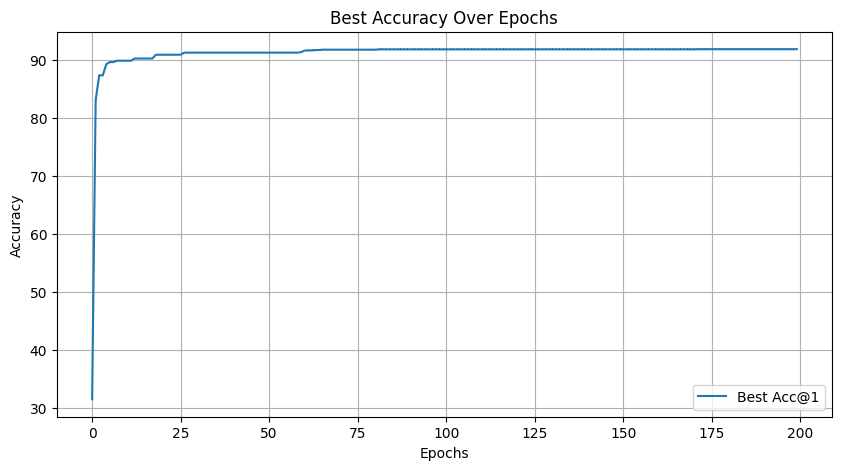

In [ ]:
import matplotlib.pyplot as plt

# Convert best accuracy list from GPU tensors to CPU float values for plotting
best_acc1_list = [float(acc.cpu()) for acc in best_acc1_list]

# Plotting the Best Accuracy Over Epochs
plt.figure(figsize=(10, 5))  # Set figure size for better visualization
plt.plot(epoch_list, best_acc1_list, label='Best Acc@1', marker=',')  # Plot accuracy values
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.title('Best Accuracy Over Epochs')  # Title of the plot
plt.legend()  # Add legend to indicate what the plot represents
plt.grid(True)  # Enable grid for easier value interpretation
plt.savefig('best_acc1_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot